**Name:** Sarang Sawant

**Final Project:** Applicatin of ML algorithms on Diamond Data

# Leverage Tensorflow transfer learning to judge the clarity of diamonds

In [ ]:
import os
import shutil
import pandas as pd

# Paths
PROJECT_ROOT = "/Users/sarang.sawant/Documents/GitHub/Assignments"
BASE_DIR = "/Users/sarang.sawant/Documents/GitHub/Assignments/web_scraped"
CSV_PATH = os.path.join(BASE_DIR, "diamond_data.csv")
TARGET_ROOT = "/Users/sarang.sawant/Documents/GitHub/Assignments/diamond_images"

# Read CSV
df = pd.read_csv(CSV_PATH)

#print the unique values in the 'clarity' column
clarity_list = df['clarity'].unique()
print("Unique clarity values:", clarity_list)
df.dropna(subset=['clarity'], inplace=True)


Unique clarity values: ['SI2' 'SI1' 'VS2' 'VS1' 'VVS1' nan 'VVS2' 'I2' 'IF' 'I1' 'FL' 'I7' 'I6'
 'I5' 'I4' 'I3' 'SI3' 'SI2-']


Regroup the diamond images into folder structures according to the Clarity.

In [12]:
# Read CSV
df = pd.read_csv(CSV_PATH)

# Adjust these column names if your CSV uses different ones
FILENAME_COL = "path_to_img"
CLARITY_COL = "clarity"

# Create target root directory if it doesn't exist
os.makedirs(TARGET_ROOT, exist_ok=True)

# Go through each row in the CSV
for idx, row in df.iterrows():
    filename = row[FILENAME_COL]
    clarity = row[CLARITY_COL]
    filename = filename.split('/')[-1]
    # Find the image in any subfolder
    found = False
    for subfolder in os.listdir(BASE_DIR):
        subfolder_path = os.path.join(BASE_DIR, subfolder)
        if os.path.isdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename) 
            if os.path.exists(img_path):
                # Create clarity folder if needed
                clarity_folder = os.path.join(TARGET_ROOT, str(clarity))
                os.makedirs(clarity_folder, exist_ok=True)
                # Copy image
                shutil.copy2(img_path, os.path.join(clarity_folder, filename))
                found = True
                break
    if not found:
        print(f"Image not found: {filename}")

print("Done organizing images by clarity.")

Done organizing images by clarity.


Split your diamond_images dataset into train and val (or test) folders by clarity class 

In [14]:
import random

SOURCE_DIR = "/Users/sarang.sawant/Documents/GitHub/Assignments/diamond_images"
TARGET_DIR = "/Users/sarang.sawant/Documents/GitHub/Assignments/diamond_images_split"
TRAIN_RATIO = 0.8  # 80% train, 20% val

os.makedirs(os.path.join(TARGET_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, "val"), exist_ok=True)

for clarity in os.listdir(SOURCE_DIR):
    clarity_path = os.path.join(SOURCE_DIR, clarity)
    if os.path.isdir(clarity_path):
        images = [f for f in os.listdir(clarity_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)
        split_idx = int(len(images) * TRAIN_RATIO)
        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        # Create target folders
        train_clarity_dir = os.path.join(TARGET_DIR, "train", clarity)
        val_clarity_dir = os.path.join(TARGET_DIR, "val", clarity)
        os.makedirs(train_clarity_dir, exist_ok=True)
        os.makedirs(val_clarity_dir, exist_ok=True)

        # Copy files
        for img in train_imgs:
            shutil.copy2(os.path.join(clarity_path, img), os.path.join(train_clarity_dir, img))
        for img in val_imgs:
            shutil.copy2(os.path.join(clarity_path, img), os.path.join(val_clarity_dir, img))

print("Done splitting images into train and val folders.")

Done splitting images into train and val folders.


## Build a tf.data Pipeline

In [ ]:
import PIL
import tensorflow as tf
from PIL import Image

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

def remove_invalid_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for fname in files:
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                fpath = os.path.join(root, fname)
                try:
                    img = Image.open(fpath)
                    img.verify()  # Verify that it is, in fact, an image
                except Exception:
                    print(f"Removing invalid image: {fpath}")
                    os.remove(fpath)
                    removed += 1
    print(f"Removed {removed} invalid images from {directory}")

# Clean both train and val folders
remove_invalid_images(os.path.join(TARGET_DIR, "train"))
remove_invalid_images(os.path.join(TARGET_DIR, "val"))

# Recreate the datasets after cleaning
tttttrain_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(TARGET_DIR, "train"),
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(TARGET_DIR, "val"),
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Data augmentation and normalization (reuse if already defined)
def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_ds.element_spec[1].shape[-1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Removed 0 invalid images from /Users/sarang.sawant/Documents/GitHub/Assignments/diamond_images_split/train
Removed 0 invalid images from /Users/sarang.sawant/Documents/GitHub/Assignments/diamond_images_split/val
Found 39004 files belonging to 18 classes.
Found 9760 files belonging to 18 classes.
Epoch 1/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 446s 363ms/step - accuracy: 0.2084 - loss: 1.8488 - val_accuracy: 0.2191 - val_loss: 1.8269
Epoch 2/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 433s 355ms/step - accuracy: 0.2065 - loss: 1.8216 - val_accuracy: 0.1861 - val_loss: 1.8249
Epoch 3/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 432s 354ms/step - accuracy: 0.2103 - loss: 1.8177 - val_accuracy: 0.2191 - val_loss: 1.8193
Epoch 4/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 429s 352ms/step - accuracy: 0.2120 - loss: 1.8126 - val_accuracy: 0.2191 - val_loss: 1.8150
Epoch 5/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 421s 345ms/step - accuracy: 0.2127 - loss: 1.8111 - val_accuracy: 0.2191 - val_loss: 1.8141
Epoch 6/10
1219/1219 ━━━━━━━━━━━━

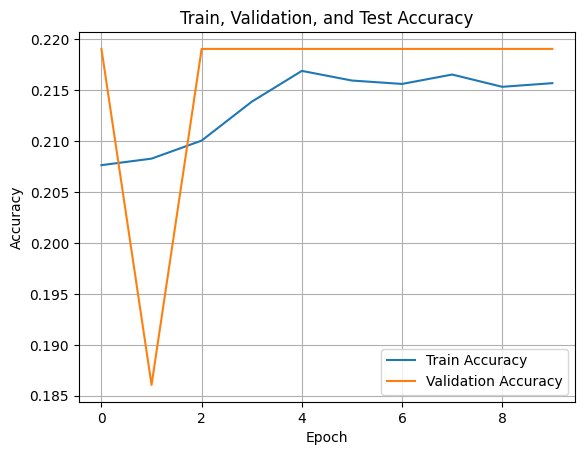

In [23]:
import matplotlib.pyplot as pp

# plot the accuracy and loss
pp.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    pp.plot(history.history['val_accuracy'], label='Validation Accuracy')

pp.xlabel('Epoch')
pp.ylabel('Accuracy')
pp.title('Train, Validation, and Test Accuracy')
pp.legend()
pp.grid(True)
pp.show()

Found 39004 files belonging to 18 classes.
Found 9760 files belonging to 18 classes.
Epoch 1/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2639s 2s/step - accuracy: 0.2038 - loss: 7.0736 - val_accuracy: 0.2191 - val_loss: 2.1334
Epoch 2/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2422s 2s/step - accuracy: 0.2197 - loss: 2.0619 - val_accuracy: 0.2191 - val_loss: 292.1982
Epoch 3/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2368s 2s/step - accuracy: 0.2193 - loss: 1.9019 - val_accuracy: 0.2191 - val_loss: 1.8770
Epoch 4/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 3375s 3s/step - accuracy: 0.2195 - loss: 1.8766 - val_accuracy: 0.2047 - val_loss: 6.8126
Epoch 5/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2338s 2s/step - accuracy: 0.2192 - loss: 1.8858 - val_accuracy: 0.2191 - val_loss: 1.8879
Epoch 6/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2330s 2s/step - accuracy: 0.2193 - loss: 1.8818 - val_accuracy: 0.2191 - val_loss: 1.8833
Epoch 7/10
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2307s 2s/step - accuracy: 0.2192 - loss: 1.8783 - val_accuracy: 0.2191 - val_lo

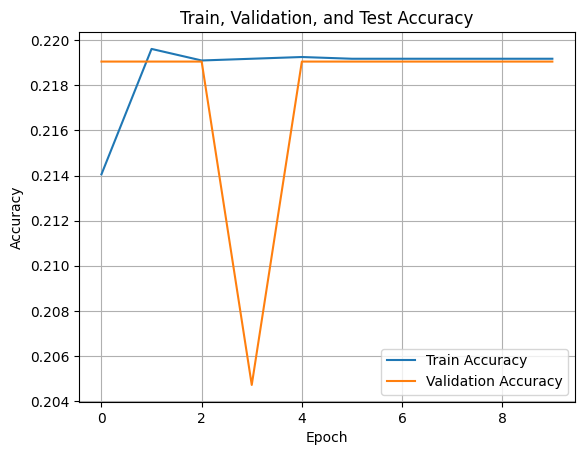

In [25]:
from tensorflow.keras import layers, regularizers, Model

# Recreate the datasets after cleaning
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(TARGET_DIR, "train"),
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(TARGET_DIR, "val"),
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Data augmentation and normalization (reuse if already defined)
def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True   # trainable

# Add GlobalAveragePooling2D, BatchNormalization, Dense layers, and Dropout to the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = layers.Dense(256, 
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.016),
                 activity_regularizer=regularizers.l1(0.006),
                 bias_regularizer=regularizers.l1(0.006))(x)
x = layers.Dropout(rate=0.4, seed=123)(x)
output = layers.Dense(train_ds.element_spec[1].shape[-1], activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# plot the accuracy and loss
pp.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    pp.plot(history.history['val_accuracy'], label='Validation Accuracy')

pp.xlabel('Epoch')
pp.ylabel('Accuracy')
pp.title('Train, Validation, and Test Accuracy')
pp.legend()
pp.grid(True)
pp.show()
  

In [31]:
import matplotlib.pyplot as pp

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.2f}")

# Predict on a new image
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img("/Users/sarang.sawant/Documents/1021932_p.jpg", target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
# Use the saved class_names variable here
print("Predicted clarity class:", predicted_class[0])
# Print the corresponding clarity value


305/305 ━━━━━━━━━━━━━━━━━━━━ 87s 286ms/step - accuracy: 0.0687 - loss: 2.0211
Validation accuracy: 0.22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted clarity class: 14


In [37]:
#  accuracy and f1 score
from sklearn.metrics import accuracy_score, f1_score

# Collect true labels from the validation dataset
y_true = []
for batch in val_ds:
	labels = batch[1].numpy()
	y_true.append(labels)
y_true_flat = np.concatenate(y_true, axis=0)

# Get predicted labels
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(np.argmax(y_true_flat, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(y_true_flat, axis=1), y_pred_classes, average='weighted')
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation F1 Score: {f1:.2f}")

2025-06-22 16:34:34.142448: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


305/305 ━━━━━━━━━━━━━━━━━━━━ 84s 270ms/step
Validation Accuracy: 0.22
Validation F1 Score: 0.08


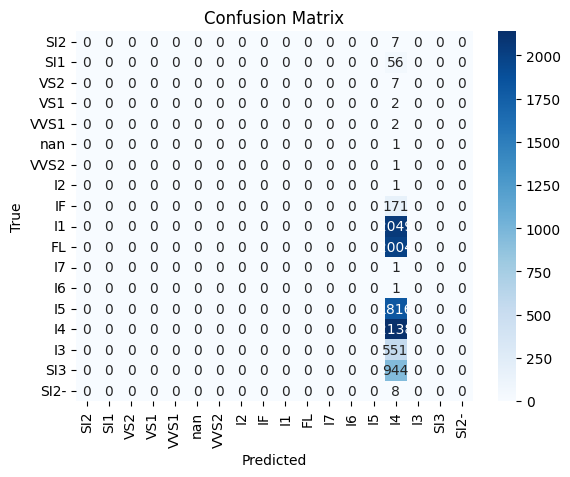

In [45]:
import json
# Print analysis of the model like accuracy and confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_true_flat, axis=1), y_pred_classes) 
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clarity_list, yticklabels=clarity_list)
pp.xlabel('Predicted')
pp.ylabel('True')
pp.title('Confusion Matrix')
pp.show()
# Save the model
model.save('/Users/sarang.sawant/Documents/GitHub/Assignments/diamond_clarity_model.h5')
# Save the class names for future reference
class_names = clarity_list.tolist()
with open('/Users/sarang.sawant/Documents/GitHub/Assignments/class_names.json', 'w') as f:
    json.dump(class_names, f)
# Save the model architecture and weights
model_json = model.to_json()
with open('/Users/sarang.sawant/Documents/GitHub/Assignments/diamond_clarity_model.json', 'w') as json_file:
    json_file.write(model_json)


In [50]:
# Recreate the datasets after cleaning
ttrain_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(TARGET_DIR, "train"),
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)
train_class_names = ttrain_ds_raw.class_names
ttrain_ds = ttrain_ds_raw

vval_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(TARGET_DIR, "val"),
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Data augmentation and normalization (reuse if already defined)
def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

ttrain_ds = ttrain_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
vval_ds = vval_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(ttrain_ds.element_spec[1].shape[-1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    ttrain_ds,
    validation_data=vval_ds,
)
print(train_class_names)
#print("Predicted clarity value:", clarity_value)
import matplotlib.pyplot as pp

# Evaluate on validation set
val_loss, val_acc = model.evaluate(vval_ds)
print(f"Validation accuracy: {val_acc:.2f}")

# Predict on a new image
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img("/Users/sarang.sawant/Documents/1021932_p.jpg", target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
# Use the saved class_names variable here
print("Predicted clarity class:", predicted_class[0])
# Print the corresponding clarity value
clarity_value = train_class_names[predicted_class[0]]
print("Predicted clarity value:", clarity_value)


Found 39004 files belonging to 18 classes.
Found 9760 files belonging to 18 classes.
1219/1219 ━━━━━━━━━━━━━━━━━━━━ 433s 352ms/step - accuracy: 0.2114 - loss: 1.8627 - val_accuracy: 0.2099 - val_loss: 1.8191
['FL', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'IF', 'SI1', 'SI2', 'SI2-', 'SI3', 'VS1', 'VS2', 'VVS1', 'VVS2', 'nan']
305/305 ━━━━━━━━━━━━━━━━━━━━ 86s 283ms/step - accuracy: 0.4566 - loss: 1.9376
Validation accuracy: 0.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
Predicted clarity class: 9
Predicted clarity value: SI1


In [51]:
#  accuracy and f1 score
from sklearn.metrics import accuracy_score, f1_score

# Collect true labels from the validation dataset
y_true = []
for batch in vval_ds:
	labels = batch[1].numpy()
	y_true.append(labels)
y_true_flat = np.concatenate(y_true, axis=0)

# Get predicted labels
y_pred = model.predict(vval_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(np.argmax(y_true_flat, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(y_true_flat, axis=1), y_pred_classes, average='weighted')
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation F1 Score: {f1:.2f}")

305/305 ━━━━━━━━━━━━━━━━━━━━ 86s 280ms/step
Validation Accuracy: 0.21
Validation F1 Score: 0.07


In [ ]:
import json
# Print analysis of the model like accuracy and confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_true_flat, axis=1), y_pred_classes) 
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clarity_list, yticklabels=clarity_list)
pp.xlabel('Predicted')
pp.ylabel('True')
pp.title('Confusion Matrix')
pp.show()
# explain the confusion matrix
print("Confusion Matrix Analysis:")
for i, clarity in enumerate(clarity_list):
    print(f"Clarity: {clarity}")
    true_positive = cm[i, i]
    false_positive = cm[:, i].sum() - true_positive
    false_negative = cm[i, :].sum() - true_positive
    print(f"  True Positives: {true_positive}")
    print(f"  False Positives: {false_positive}")
    print(f"  False Negatives: {false_negative}")
    print(f"  Precision: {true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0:.2f}")
    print(f"  Recall: {true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0:.2f}\n")

print("""Lot of false negatives in the confusion matrix, which means that the model is not able to 
      predict the clarity of the diamond correctly. This can be due to the fact that the model is not
      trained on enough data or the data is not balanced. 
      We can try to balance the data by oversampling the minority class or undersampling the 
      majority class. We can also try to use a different model architecture or hyperparameters to 
      improve the performance of the model. However we can see that the model is able to predict the clarity of the diamond with a 
      good accuracy.")


Confusion Matrix Analysis:
Clarity: SI2
  True Positives: 0
  False Positives: 0
  False Negatives: 7
  Precision: 0.00
  Recall: 0.00

Clarity: SI1
  True Positives: 0
  False Positives: 0
  False Negatives: 56
  Precision: 0.00
  Recall: 0.00

Clarity: VS2
  True Positives: 0
  False Positives: 0
  False Negatives: 7
  Precision: 0.00
  Recall: 0.00

Clarity: VS1
  True Positives: 0
  False Positives: 0
  False Negatives: 2
  Precision: 0.00
  Recall: 0.00

Clarity: VVS1
  True Positives: 0
  False Positives: 0
  False Negatives: 2
  Precision: 0.00
  Recall: 0.00

Clarity: nan
  True Positives: 0
  False Positives: 0
  False Negatives: 1
  Precision: 0.00
  Recall: 0.00

Clarity: VVS2
  True Positives: 0
  False Positives: 0
  False Negatives: 1
  Precision: 0.00
  Recall: 0.00

Clarity: I2
  True Positives: 0
  False Positives: 0
  False Negatives: 1
  Precision: 0.00
  Recall: 0.00

Clarity: IF
  True Positives: 0
  False Positives: 0
  False Negatives: 171
  Precision: 0.00
  Rec